# Interpolating station data using Kriging

In this notebook we will apply Kriging to interpolate sparsely spaced rain-guage measurement. This example came out of questions from Norenyi.

*NOTE*: The "data" used here have been randomly generated to mimick actual observations but are not real data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import xarray as xr

from pykrige.ok import OrdinaryKriging
import pykrige.kriging_tools as kt

import tqdm

%matplotlib inline

In [2]:
posns = np.loadtxt('station_coords.txt')

In [3]:
lat = posns[:,0]
lon = posns[:,1]

In [4]:
lat, lon

(array([ 12.91075 ,  12.87873 ,  13.02304 ,  13.14408 ,  14.72831 ,
         14.89437 ,  14.7399  ,  14.79101 ,  14.42284 ,  14.47593 ,
         14.33902 ,  14.79779 ,  13.81425 ,  14.05663 ,  13.83333 ,
         13.85223 ,  14.24454 ,  14.15517 ,  13.78214 ,  13.8778  ,
         14.49571 ,  14.12846 ,  14.28492 ,  13.82796 ,  14.1052  ,
         13.98021 ,  16.66006 ,  16.40084 ,  16.51011 ,  14.7645  ,
         14.64177 ,  14.71199 ,  14.80385 ,  13.95    ,  14.27025 ,
         13.74372 ,  15.61418 ,  15.833001,  15.43917 ,  15.27682 ,
         15.28201 ,  15.27694 ,  15.35588 ,  15.39611 ,  15.20084 ,
         15.1464  ,  15.96508 ,  16.45888 ,  15.92264 ,  16.03263 ,
         14.90267 ,  14.45811 ,  14.18587 ,  13.77259 ,  12.56046 ,
         12.6342  ,  12.83637 ,  13.66511 ,  12.56415 ,  12.80509 ,
         12.3614  ,  12.51127 ,  13.03962 ,  12.7896  ,  12.75878 ]),
 array([-14.95057 , -14.48106 , -13.92856 , -14.10594 , -16.25221 ,
        -16.20368 , -16.10958 , -16.93586 , -1

In [5]:
matfile = scipy.io.loadmat('rain_data.mat')
rain_data = matfile['rain_amount']
rain_data

array([[ 0.31322983,  0.45349554,  0.46272309,  0.3660775 ,  0.37952753,
         0.45589351,  0.35647969,  0.53295111,  0.50653705,  0.31127781,
         0.25245851,  0.3364385 ,  0.04258479,  0.10353309,  0.09983582,
        -0.00423946,  0.15972229,  0.06676435,  0.03727326,  0.04994738,
         0.21297511,  0.04429125,  0.10865119,  0.05097502,  0.06180249,
         0.21356927,  0.23598685, -0.05208595,  0.04714911,  0.575164  ,
         0.39113937,  0.30773404,  0.3663455 ,  0.03182767,  0.09124713,
        -0.0035462 ,  0.74215633,  0.77888896,  0.60488798,  0.54412196,
         0.64896869,  0.640371  ,  0.6018466 ,  0.44242908,  0.73317627,
         0.40994386,  0.2405558 ,  0.73272037,  0.69990782,  0.6608668 ,
         0.79210483,  0.74080432,  0.47787977,  0.24474747,  0.42563016,
         0.62029052,  0.21362877,  0.22007872,  0.20132465,  0.14066384,
         0.30817364,  0.2679189 ,  0.11266831,  0.19694141,  0.16369723],
       [ 0.25873959,  0.1038712 ,  0.11631741,  0.

In [6]:
ds_in = xr.Dataset(
    coords=dict(
        station_number=np.arange(rain_data.shape[1]),
        timestep=np.arange(rain_data.shape[0])
    ),
)

ds_in['lat'] = (('station_number', ), lat)
ds_in['lon'] = (('station_number', ), lon)
ds_in['rain'] = (('timestep', 'station_number'), rain_data)
ds_in

<xarray.Dataset>
Dimensions:         (station_number: 65, timestep: 5)
Coordinates:
  * station_number  (station_number) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 ...
  * timestep        (timestep) int64 0 1 2 3 4
Data variables:
    lat             (station_number) float64 12.91 12.88 13.02 13.14 14.73 ...
    lon             (station_number) float64 -14.95 -14.48 -13.93 -14.11 ...
    rain            (timestep, station_number) float64 0.3132 0.4535 0.4627 ...

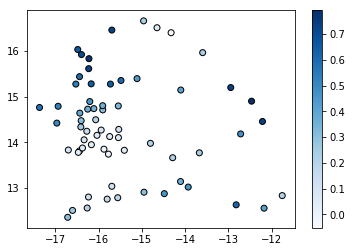

In [7]:
# lets plot the rain data to see what it looks like
ds_ = ds_in.isel(timestep=0)

cmap = plt.cm.get_cmap('Blues')

sc = plt.scatter(ds_.lon, ds_.lat, c=ds_.rain, vmin=ds_.rain.min(), vmax=ds_.rain.max(), 
                 cmap=cmap, edgecolor='black')

plt.colorbar()

In [8]:
# new grid points that we will interpolate onto
lon_new = np.linspace(lon.min(), lon.max(), 100)
lat_new = np.linspace(lat.min(), lat.max(), 100)

In [9]:
# defining xarray (to create netcdf output)
Nt = rain_data.shape[0]

ds = xr.Dataset(
    coords=dict(
        time=np.arange(Nt),
        lat=lat_new,
        lon=lon_new,
    )
)

# arrays we will fill with data later
ds['rain'] = xr.DataArray(
    data=np.empty((Nt, len(lat_new), len(lon_new))),
    coords=ds.coords,
    dims=('time', 'lat', 'lon'),
    attrs=dict(units='mm')
)
ds['rain_err'] = xr.DataArray(
    data=np.empty((Nt, len(lat_new), len(lon_new))),
    coords=ds.coords,
    dims=('time', 'lat', 'lon'),
    attrs=dict(units='mm', long_name='error in rain estimate')
)
ds.lon.attrs['units'] = 'deg'
ds.lat.attrs['units'] = 'deg'

In [10]:
ds

<xarray.Dataset>
Dimensions:   (lat: 100, lon: 100, time: 5)
Coordinates:
  * time      (time) int64 0 1 2 3 4
  * lat       (lat) float64 12.36 12.4 12.45 12.49 12.54 12.58 12.62 12.67 ...
  * lon       (lon) float64 -17.37 -17.31 -17.25 -17.2 -17.14 -17.08 -17.03 ...
Data variables:
    rain      (time, lat, lon) float64 6.915e-310 6.915e-310 1.978e-316 ...
    rain_err  (time, lat, lon) float64 6.915e-310 6.915e-310 2.046e-316 ...

In [11]:
for tn in tqdm.tqdm(range(rain_data.shape[0])):
    rr_day = ds_in.sel(timestep=tn).rain.values
    
    
    if rr_day.min() == rr_day.max():
        # if there's no difference we don't need to do any Kriging
        rr = rr_day.min()
        rr_err = 0.0
    else:
        # filter out stations where there is no data
        index_stations_ok = np.logical_not(np.isnan(rr_day))
        rr_day_ok = rr_day[index_stations_ok]
        lat_ok = lat[index_stations_ok]
        lon_ok = lon[index_stations_ok]
        
        if len(rr_day_ok) == 0:
            rr = np.nan
            rr_err = np.nan
        else:
            OK = OrdinaryKriging(lon_ok, lat_ok, rr_day_ok, variogram_model='linear', coordinates_type='geographic')
        
            rr, rr_err = OK.execute('grid', lon_new, lat_new)
                        
        #rint(rr.min(), rr.max(), rr_day.min(), rr_day.max())
    
    # store the interpolated values for this timestep into the dataset
    ds.rain.values[tn] = rr
    ds.rain_err.values[tn] = rr_err
    
ds

100%|██████████| 5/5 [00:00<00:00, 11.12it/s]


<xarray.Dataset>
Dimensions:   (lat: 100, lon: 100, time: 5)
Coordinates:
  * time      (time) int64 0 1 2 3 4
  * lat       (lat) float64 12.36 12.4 12.45 12.49 12.54 12.58 12.62 12.67 ...
  * lon       (lon) float64 -17.37 -17.31 -17.25 -17.2 -17.14 -17.08 -17.03 ...
Data variables:
    rain      (time, lat, lon) float64 0.2514 0.2494 0.2475 0.2457 0.2439 ...
    rain_err  (time, lat, lon) float64 0.05394 0.05362 0.05331 0.05299 ...

(<xarray.DataArray 'rain' ()>
 array(0.015769419724192383), <xarray.DataArray 'rain' ()>
 array(0.7318696038353426))

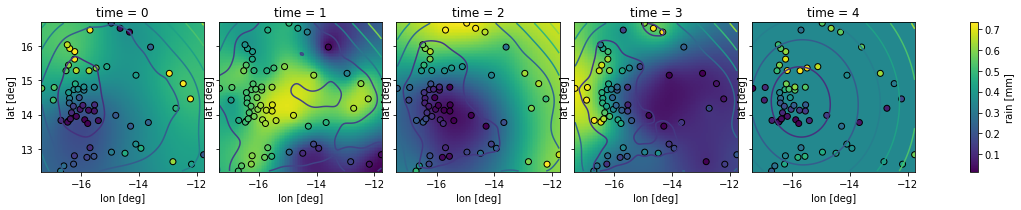

In [12]:
facetgrid = ds.rain.plot(col='time')

for tn, subgrid in zip(ds.time.values, facetgrid.axes.flatten()):

    ax = subgrid
    pcolor = subgrid.collections[0]

    ax.scatter(lon, lat, c=rain_data[tn], cmap=pcolor.cmap, norm=pcolor.norm, edgecolor='black')
    ds.sel(time=tn).rain_err.plot.contour(ax=ax)

ds.rain.min(), ds.rain.max()

**NB**: Some of the estimated rain rates can be below zero! Should look into details of Kriging to determine optimal method. Maybe data needs filtering before Kriging is applied? Also, sometimes the method appears to simply fail (time=4)

In [13]:
# save interpolate data to a netCDF file
ds.to_netcdf('kriging_output.nc')

In [14]:
# For generating random station data
import os

if not os.path.exists('rain_data.mat'):
    from scipy.ndimage.interpolation import zoom
    import scipy.interpolate

    nt = 5
    nx, ny = 100, 100

    def generate_rainfall(s=20):
        m_coarse = (np.random.uniform(size=(nx//s,ny//s))*5).astype(int)/5
        m = zoom(m_coarse, s)
        return m


    rain_amount = np.random.random((nt, len(lat)))
    for tn in np.arange(nt):
        r_grid = generate_rainfall()
        fn = np.vectorize(scipy.interpolate.interp2d(x=lon_new, y=lat_new, z=r_grid))
        r_points = fn(lon, lat)
        rain_amount[tn] = r_points

    scipy.io.savemat('rain_data.mat', dict(rain_amount=rain_amount))